In [1]:
from self_supervised.pipelines.representation_model import RepresentationModel, YoloEncoder
from ultralytics.models.yolo.detect.train import DetectionModel
import torch

%reload_kedro
model_description = catalog.load("yolov8_l_description")
# trained_model = catalog.load("trained_model", version="2023-03-23T12.37.00.000Z")
trained_model = torch.load("../models/checkpoints/checkpoint_31889.pt", map_location="cpu")

# Random model
# encoder = YoloEncoder(model_description=model_description)
# trained_model = RepresentationModel(encoder=encoder)

# CoCO model
# model_description["head"] = model_description["head"][:-1]
# trained_model = DetectionModel(model_description)
# weights_model = torch.load("../yolov5l.pt", map_location="cpu")
# state_dict = weights_model["model"].float().state_dict()
# trained_model.load_state_dict(state_dict, strict=False)

projection = trained_model.projection
trained_model = trained_model.encoder
trained_model = trained_model.eval()
projection = projection.eval()

2024-10-01 14:42:43,464 - kedro.ipython - INFO - Resolved project path as: /home/daniel/git/self-supervised-learning.
To set a different path, run '%reload_kedro <project_root>'
2024-10-01 14:42:43,473 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/kedro/framework/startup.py:99: KedroDeprecationWarning: project_version in pyproject.toml is deprecated, use kedro_init_version instead
  warnings.warn(

2024-10-01 14:42:43,615 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/kedro/framework/session/session.py:267: KedroDeprecationWarning: TemplatedConfigLoader will be deprecated in Kedro 0.19. Please use the OmegaConfigLoader instead. To consult the documentation for OmegaConfigLoader, see here: https://docs.kedro.org/en/stable/configuration/advanced_configuration.html#omegaconfigloader
  warnings.warn(

2024-10-01 14:42:43,642 - py.warnings - WARNING - /home/daniel/git/self-superv

In [2]:
from pathlib import Path

dataset_path = Path("/home/daniel/lab_share/projects/CottonFlower2021/flower_dataset")

In [3]:
from torchvision.io import read_image
from torchvision.transforms.functional import resize
from tqdm import tqdm
import torch
from typing import Tuple, List
import numpy as np

def extract_image_reps(image_list: List[Path]) -> Tuple[List[np.array], List[np.array]]:
    image_reps = []
    image_reps_low_dim = []

    for image_path in tqdm(image_list):
        image = read_image(image_path.as_posix())
        image.requires_grad = False
        image = resize(image, (512, 512))
        image = image.to(torch.float) / 255
        image_ex = image[None, :, :, :]

        image_rep = trained_model(image_ex).detach()
        image_reps.append(image_rep[0].reshape((1, -1)).numpy())
        image_reps_low_dim.append(projection(image_rep)[0].detach().reshape((1, -1)).numpy())
                          
    return image_reps, image_reps_low_dim


def extract_image_reps_dir(image_dir_: Path) -> Tuple[List[np.array], List[np.array]]:
    image_list = sorted(list(image_dir_.iterdir()))
    return extract_image_reps(image_list)

In [4]:
# Extract image reps.
ground_image_reps_1, _ = extract_image_reps_dir(dataset_path / "ssl_active_3" / "images")
ground_image_reps_2, _ = extract_image_reps_dir(dataset_path / "ssl_active_4" / "images")
aerial_image_reps_1, _ = extract_image_reps_dir(dataset_path / "active_1" / "images")
aerial_image_reps_2, _ = extract_image_reps_dir(dataset_path / "2018-08-22" / "images")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:32<00:00,  4.90it/s]


In [5]:
import pandas as pd
from typing import List
import numpy as np

def read_labels(labels_dir: Path, image_reps: List[np.array]) -> List[int]:
    all_labels = []
    labels_list = sorted(list(labels_dir.iterdir()))
    for labels_path in labels_list:
        frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
        frame_labels["frame"] = labels_path.name
        all_labels.append(frame_labels)

    all_labels = pd.concat(all_labels, ignore_index=True)
    
    # Create flower counts labels.
    flower_counts = []
    for labels_path in labels_list:
        flower_counts.append(np.count_nonzero(all_labels["frame"] == labels_path.name))

    # Any missing counts are zeros.
    for _ in range(len(flower_counts), len(image_reps)):
        flower_counts.append(0)
        
    return flower_counts

In [6]:
# Extract flower counts.
ground_counts_1 = read_labels(dataset_path / "ssl_active_3" / "labels", ground_image_reps_1)
ground_counts_2 = read_labels(dataset_path / "ssl_active_4" / "labels", ground_image_reps_2)
aerial_counts_1 = read_labels(dataset_path / "active_1" / "labels", aerial_image_reps_1)
aerial_counts_2 = read_labels(dataset_path / "2018-08-22" / "labels", aerial_image_reps_2)

In [7]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd

def compute_tsne(image_reps: np.array, labels: np.array, perplexity: int = 10, **kwargs) -> pd.DataFrame:
    pca = PCA(n_components=50)
    pca.fit(image_reps)
    pca_reps = pca.transform(image_reps)

    tsne = TSNE(perplexity=perplexity)
    embedded_reps = tsne.fit_transform(pca_reps)

    # Combine embeddings with plot status data.
    return pd.DataFrame(data=dict(x=embedded_reps[:, 0], y=embedded_reps[:, 1], labels=labels, **kwargs))

In [8]:
all_counts = np.array(ground_counts_1 + ground_counts_2 + aerial_counts_1 + aerial_counts_2)
all_image_reps = np.concatenate(ground_image_reps_1 + ground_image_reps_2 + aerial_image_reps_1 + aerial_image_reps_2)

# Combine embeddings with number of flowers and source data.
platform_type = ["ground" for _ in ground_image_reps_1 + ground_image_reps_2] + ["aerial" for _ in aerial_image_reps_1 + aerial_image_reps_2]
embedded_df = compute_tsne(all_image_reps, all_counts, Platform=platform_type, perplexity=100)
embedded_df.rename({"labels": "# of Flowers"}, axis="columns", inplace=True)
embedded_df

,x,y,# of Flowers,Platform
0,9.339543,-1.851679,3,ground
1,7.751932,-0.893523,0,ground
2,5.314801,6.624076,2,ground
3,5.382317,6.765826,2,ground
4,-4.157597,4.341578,0,ground
...,...,...,...,...
435,1.040064,-1.865567,6,aerial
436,1.368823,-0.100136,2,aerial
437,2.142893,6.297277,1,aerial
438,1.340182,5.523169,3,aerial


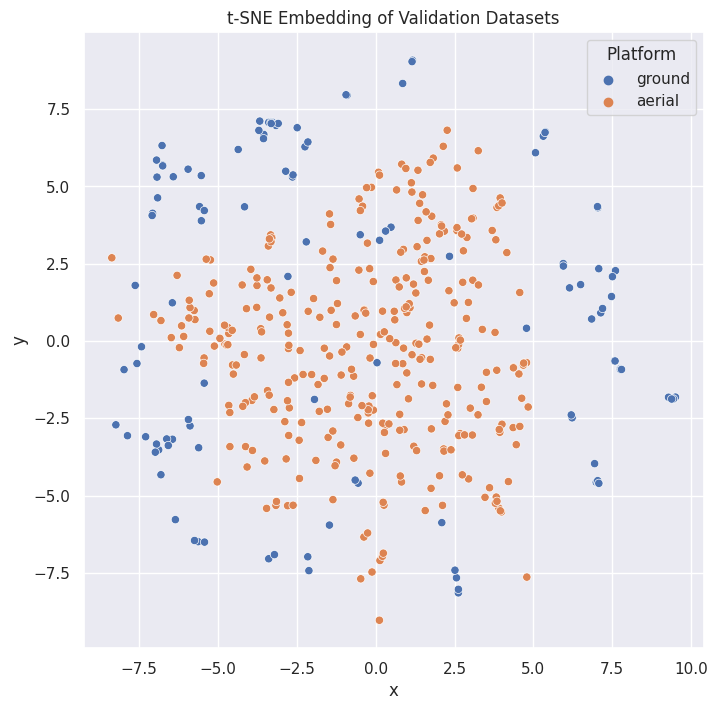

In [9]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={"figure.figsize":(8, 8)})

sns.scatterplot(data=embedded_df, x="x", y="y", hue="Platform").set(title="t-SNE Embedding of Validation Datasets")
plt.legend(title="Platform")

In [10]:
# Compute TSNE for aerial only.
aerial_embedded_df = compute_tsne(np.concatenate(aerial_image_reps_1 + aerial_image_reps_2, axis=0), np.array(aerial_counts_1 + aerial_counts_2).astype(int), perplexity=10)
aerial_embedded_df.rename({"labels": "# of Flowers"}, axis="columns", inplace=True)
aerial_embedded_df

,x,y,# of Flowers
0,24.954231,21.210255,1
1,-0.839165,-11.352185,1
2,19.737951,-18.725777,8
3,11.590704,-24.283735,0
4,26.057510,-21.650888,1
...,...,...,...
315,22.830629,3.782523,6
316,10.853147,-1.129055,2
317,11.083538,42.260693,1
318,1.365435,36.336380,3


[Text(0.5, 1.0, 't-SNE Embedding of Aerial Dataset')]

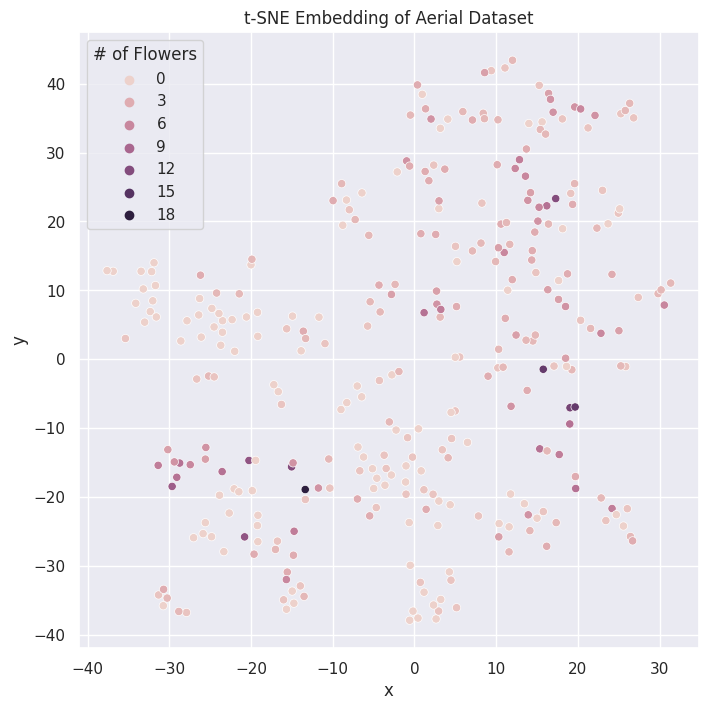

In [11]:
sns.scatterplot(data=aerial_embedded_df, x="x", y="y", hue="# of Flowers").set(title="t-SNE Embedding of Aerial Dataset")

In [12]:
# Compute TSNE for ground only.
ground_embedded_df = compute_tsne(np.concatenate(ground_image_reps_1 + ground_image_reps_2, axis=0), np.array(ground_counts_1 + ground_counts_2).astype(int), perplexity=10)
ground_embedded_df.rename({"labels": "# of Flowers"}, axis="columns", inplace=True)
ground_embedded_df

,x,y,# of Flowers
0,-5.647555,-26.498104,3
1,-1.028213,-25.190739,0
2,-18.936628,15.891641,2
3,-18.727386,18.744978,2
4,-9.632238,13.481237,0
...,...,...,...
115,20.067183,-9.586787,0
116,20.944551,-0.019728,0
117,1.694100,-20.875061,0
118,23.958082,-10.270275,1


[Text(0.5, 1.0, 't-SNE Embedding of Ground Dataset')]

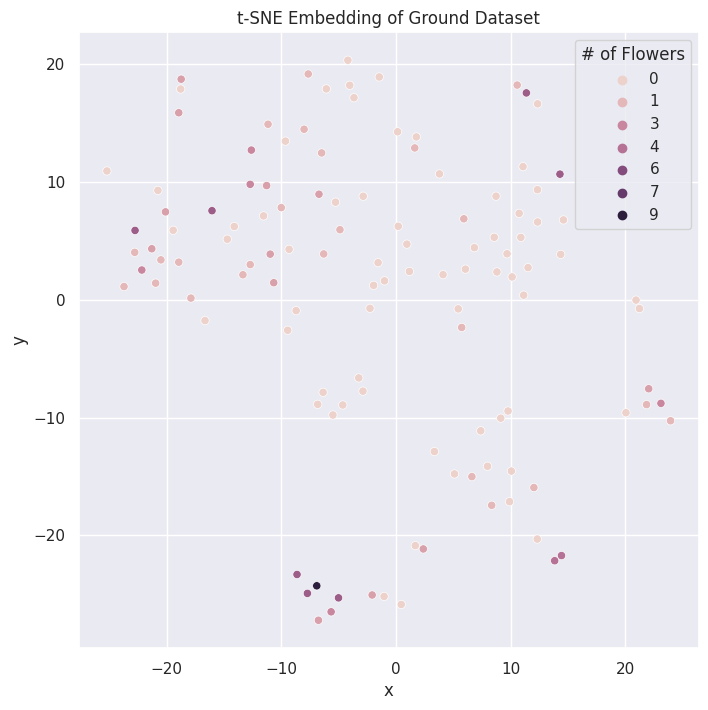

In [13]:
sns.scatterplot(data=ground_embedded_df, x="x", y="y", hue="# of Flowers").set(title="t-SNE Embedding of Ground Dataset")

In [14]:
# Load the plot status data.
PLOT_STATUS_DATA_PATH = Path("/home/daniel/lab_share/projects/SSL/plot_status_dataset")
train_dir = PLOT_STATUS_DATA_PATH / "train"
test_dir = PLOT_STATUS_DATA_PATH / "test"

LABEL_MAP = {"in_plot": 0, "between_plots": 1, "headland": 2}

def collect_images_and_labels(data_dir: Path) -> Tuple[List[Path], np.array]:
    image_paths = []
    labels = []

    for category_dir in data_dir.iterdir():
        for image_path in category_dir.iterdir():
            image_paths.append(image_path)
            labels.append(LABEL_MAP[category_dir.name])

    return image_paths, np.array(labels)

train_images, train_labels = collect_images_and_labels(train_dir)
test_images, test_labels = collect_images_and_labels(test_dir)

In [15]:
# Compute image representations.
train_image_reps, _ = extract_image_reps(train_images)
test_image_reps, _ = extract_image_reps(test_images)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.77it/s]


In [59]:
plot_status_embedded_df = compute_tsne(np.concatenate(train_image_reps + test_image_reps), np.concatenate([train_labels, test_labels]), perplexity=7)
plot_status_embedded_df.rename({"labels": "Plot Status"}, axis="columns", inplace=True)
plot_status_embedded_df

,x,y,Plot Status
0,6.969551,9.462008,0
1,-13.603469,2.364179,0
2,12.916077,10.277931,0
3,10.088529,10.217648,0
4,6.454939,24.881241,0
...,...,...,...
65,-13.727707,-21.796501,0
66,16.030363,10.220361,0
67,7.751654,7.623454,0
68,9.641232,17.736349,0


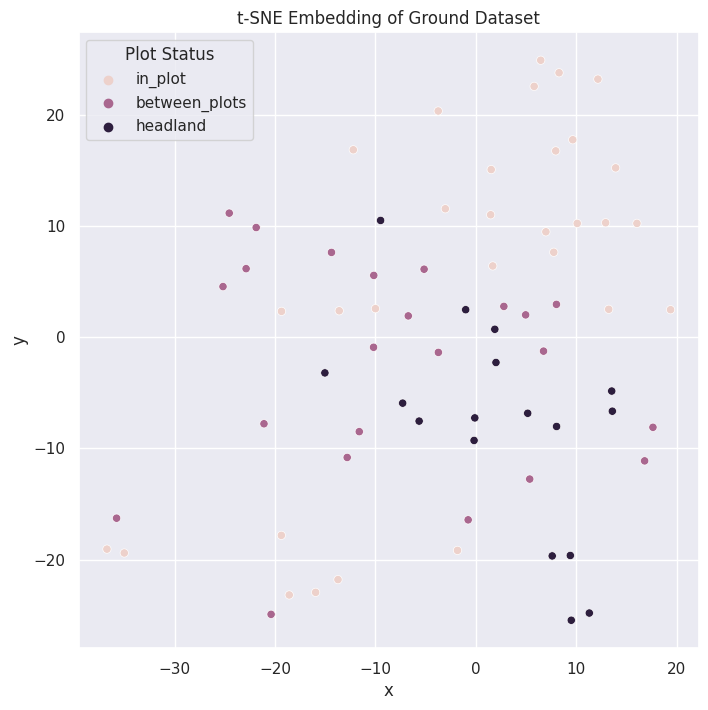

In [63]:
import seaborn as sns

scatter = sns.scatterplot(data=plot_status_embedded_df, x="x", y="y", hue="Plot Status")
scatter.set(title="t-SNE Embedding of Ground Dataset")

# Replace the labels to be more readable.
handles, labels = scatter.get_legend_handles_labels()
new_labels = list(LABEL_MAP.keys())
# Create a new legend with the updated labels
plt.legend(handles=handles, labels=new_labels, title="Plot Status")
